In [1]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint, NonlinearConstraint
import time
from single_pendulum_task import single_pendulum_task as SPT
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
spt = SPT()

### Basis functions. Providing Phi_T, Rw

Radial Basis Functions

In [3]:
def get_RBF_basis(t, center, width):
    d = center-t

    b = np.exp(- np.power(d,2) / (2*width))
    sb = np.sum(b)
    phi = np.divide(b,sb)

    db = b * d / width
    sdb = np.sum(db)
    dphi = (db - phi * sdb) / sb

    ddb = (- b + d * db) / width
    sddb = np.sum(ddb)
    ddphi = (ddb - 2 * dphi * sdb - phi * sddb) / sb
    
    Phi_ = np.zeros((spt.ndof,num_basis*spt.ndof))
    dPhi_ = np.zeros((spt.ndof,num_basis*spt.ndof))
    ddPhi_ = np.zeros((spt.ndof,num_basis*spt.ndof))

    for n in range(spt.ndof):
        Phi_[n,n*num_basis:(n+1)*num_basis] = phi
        dPhi_[n,n*num_basis:(n+1)*num_basis] = dphi
        ddPhi_[n,n*num_basis:(n+1)*num_basis] = ddphi

    return Phi_, dPhi_, ddPhi_

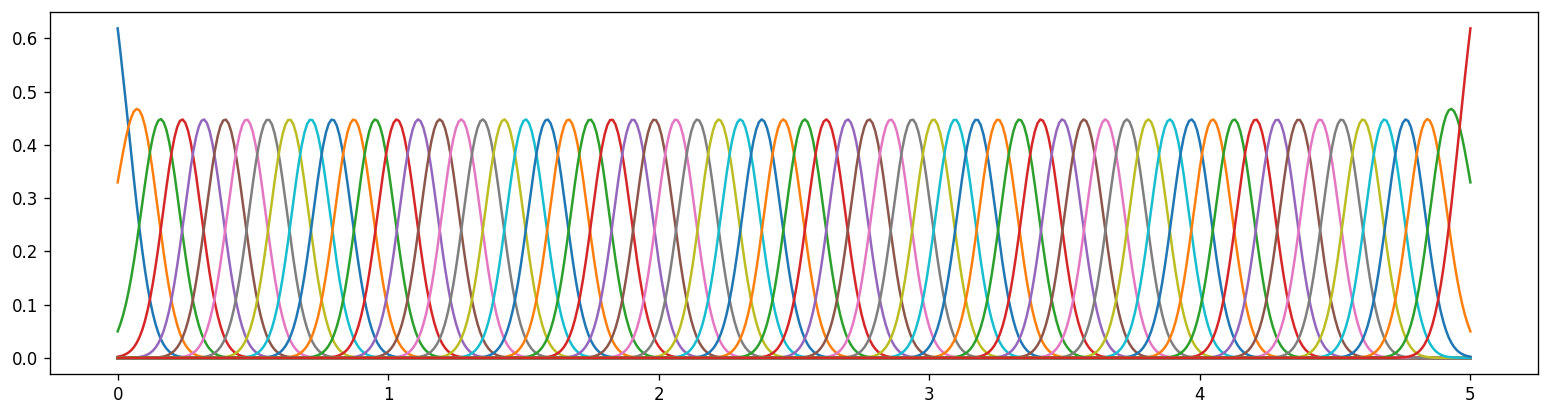

In [12]:
# num_basis = 32
# width = 0.02
num_basis = 64
width = 0.005
center = np.linspace(0, spt.T, num_basis)

Phi = np.zeros((len(spt.t_cost_array)*spt.ndof, num_basis*spt.ndof))
dPhi = np.zeros_like(Phi)
ddPhi = np.zeros_like(Phi)

for i in range(len(spt.t_cost_array)):
    Phi[i*spt.ndof:(i+1)*spt.ndof], dPhi[i*spt.ndof:(i+1)*spt.ndof], ddPhi[i*spt.ndof:(i+1)*spt.ndof] = get_RBF_basis(spt.t_cost_array[i], center, width)

spt.set_basis(Phi, dPhi, ddPhi)

w_init = np.ones(num_basis*spt.ndof)
for i in range(spt.ndof):
    w_init[i*num_basis:(i+1)*num_basis] = spt.q_0[i]# np.random.uniform(q_low, q_high)

plt.figure(figsize=(16, 4), dpi=120, facecolor='w', edgecolor='k')
for i in range(num_basis):
    plt.plot(spt.t_cost_array, Phi[::spt.ndof, i])

### Sequential least-squares quadratic programming

In [13]:
def fun(w):
    return spt.alpha_control * spt.control_cost(w)

def grad(w):
    return spt.alpha_control * spt.control_grad(w)

constraints = []
constraints.append(LinearConstraint(np.eye(num_basis), -2*np.pi*np.ones(num_basis)-1e-6, 2*np.pi*np.ones(num_basis)+1e-6))
constraints.append(LinearConstraint(Phi[:spt.ndof], spt.q_0-1e-6, spt.q_0+1e-6))
constraints.append(LinearConstraint(Phi[-spt.ndof:], spt.q_d-1e-6, spt.q_d+1e-6))
constraints.append(LinearConstraint(dPhi[:spt.ndof],  -1e-6, +1e-6))
constraints.append(LinearConstraint(dPhi[-spt.ndof:], -1e-6, +1e-6))
constraints.append(NonlinearConstraint(spt.inverse_dynamics, -spt.tau_lim*np.ones(len(spt.t_cost_array)), spt.tau_lim*np.ones(len(spt.t_cost_array))))

In [14]:
start = time.time()

res = minimize(fun, w_init, method='SLSQP', jac=grad, bounds=None, constraints=constraints, options={'maxiter': 1000, 'ftol': 1e-8, 'disp': True})
#res = minimize(fun, np.concatenate((p_init, [T])), method='SLSQP', bounds=None, constraints=constraints, options={'ftol': 1e-8, 'disp': True})

duration = time.time()-start

print("Elapsed time: ", duration," [s]")

#print(res.x, get_dq_max(res.x), get_ddq_max(res.x))
w_opt = res.x

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 0.015611797303952108
            Iterations: 98
            Function evaluations: 265
            Gradient evaluations: 94
Elapsed time:  11.517113208770752  [s]


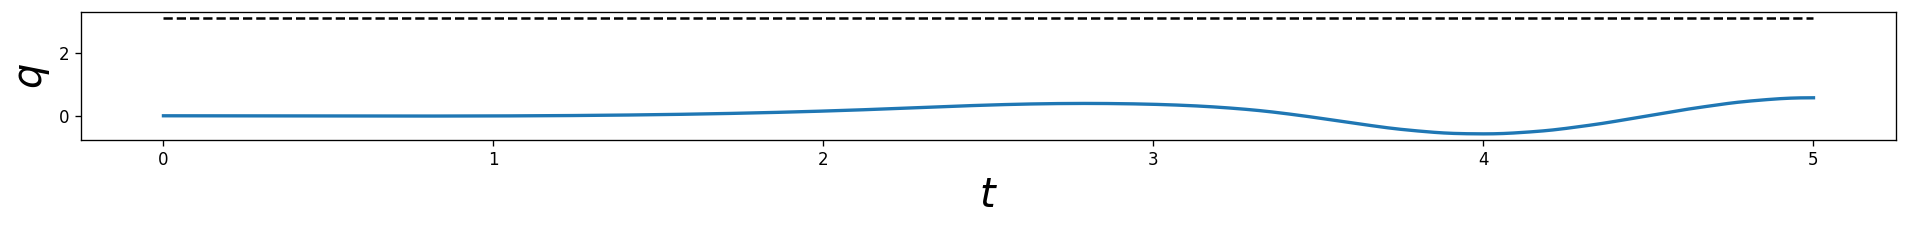

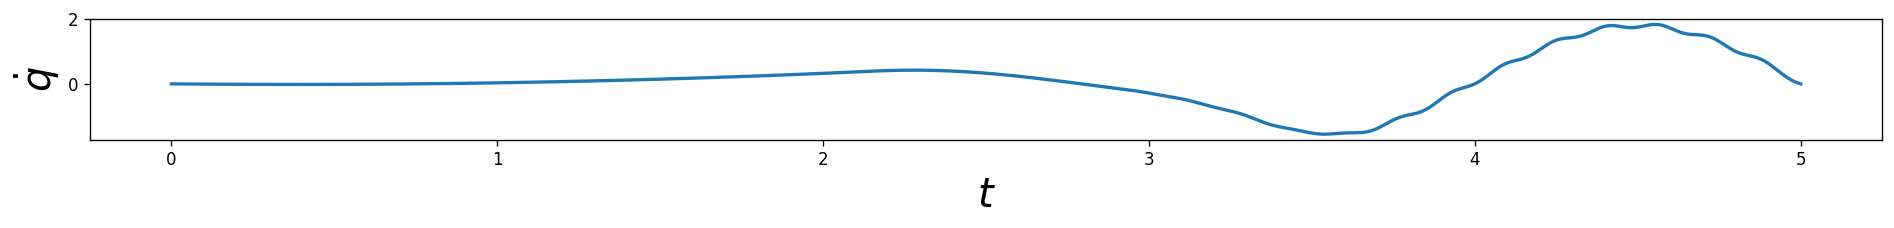

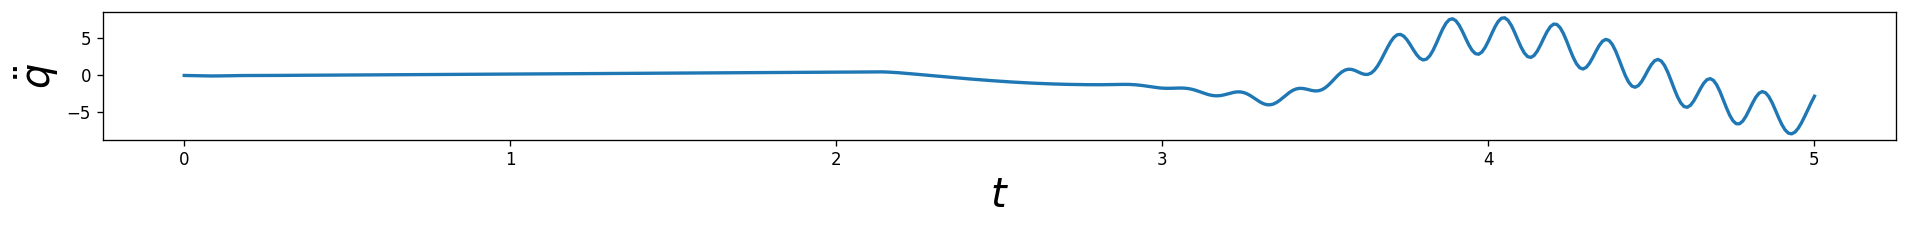

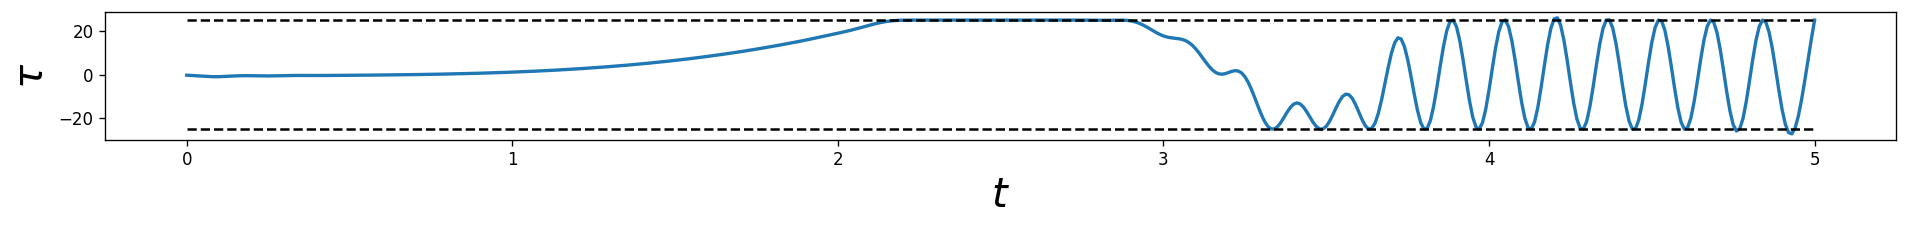

In [15]:
spt.plot_q(w_opt)
spt.plot_dq(w_opt)
spt.plot_ddq(w_opt)
spt.plot_tau(w_opt)

In [16]:
#spt.save_animation(w_opt)